In [1]:
import time
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from brax import envs
from brax.io import mjcf
import jax
import flax.linen as nn
import jax.numpy as jnp
from wrappers import AutoResetWrapper

from custom_types import RNGKey, EnvState, Params
from typing import Any, Tuple, List
# from algorithms import QuaraticPPO, PPO
# from mo_algorithms import MO_PPO
from algorithms import MOPPO, PPOConfigs
from imitation_learning_emitter import ILConfigs, IL_emitter
from buffer import PPOTransition
from networks import GCMLP, GC_PPO_Policy, PPO_Policy, MLP
from functools import partial
from utils import shuffle_transitions
from mo_utils import sample_task
# , mo_ppo_exploraive_rollout, calculate_td_lambda_returns, build_scoring_fn

/home/runjun/Documents/python_envs/jax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
critic_hidden_layers: Tuple[int, ...] = (128, 128)
actor_hidden_layers: Tuple[int, ...] = (128, 128)

vec_env = 4096
pop_size = 1

ppo_config = PPOConfigs(
    policy_learnng_rate=5e-4,
    critic_learning_rate=5e-4,
    clip_ratio=0.2,
    entropy_gain=0.0,
    discount=0.99,
    td_lambda_discount=0.95,
    rollout_length=128,
    vec_env=vec_env,
    mini_batch_size=512,
    critic_epochs=4,
    policy_epochs=4,
    learnable_std=False,
    initial_std=0.2,
    std_decay_rate=0.0,
    min_std=0.1,
)

il_config = ILConfigs(
    stage_steps=4,
    stage_iter=8,
    popsize=pop_size,
    policy_epochs=8,
    critic_epochs=8,
    mini_batch_size=512,
    policy_learnng_rate=5e-4, # imitation learning
    critic_learning_rate=5e-4, # imitation learning
    initial_std=0.1,
    std_decay_rate=0.0,
    min_std=0.1,
)


In [3]:
# set random seed
seed = 6666
loop_random_key = jax.random.PRNGKey(seed)
loop_random_key, subkey = jax.random.split(loop_random_key)
task_name = "ant"

# creat environment (Ant)
env = envs.create(env_name=task_name, episode_length=None, backend="positional", auto_reset=False)
env = AutoResetWrapper(env) # custom auto reset

In [4]:
critic_hidden_layers: Tuple[int, ...] = (128, 128)
# res_hidden_layers: Tuple[int, ...] = (64, 64)
actor_hidden_layers: Tuple[int, ...] = (128, 128)

policy_network = GC_PPO_Policy(
    hidden_layer_sizes=actor_hidden_layers,
    action_dim=env.action_size,
    initial_std=0.1 * jnp.ones(env.action_size),
    kernel_init=jax.nn.initializers.orthogonal(jnp.sqrt(2)),
    kernel_init_final=jax.nn.initializers.orthogonal(0.01),
    # activation=nn.softplus,
    activation=nn.softplus,
    final_activation=jnp.tanh,
    fixed_std=True,
)

offpring_network = PPO_Policy(
    hidden_layer_sizes=actor_hidden_layers,
    action_dim=env.action_size,
    initial_std=0.1 * jnp.ones(env.action_size),
    kernel_init=jax.nn.initializers.orthogonal(jnp.sqrt(2)),
    kernel_init_final=jax.nn.initializers.orthogonal(0.01),
    # activation=nn.softplus,
    activation=nn.softplus,
    final_activation=jnp.tanh,
    fixed_std=True,
)

critic_network = GCMLP(
    layer_sizes=critic_hidden_layers + (1,),
    kernel_init=jax.nn.initializers.orthogonal(jnp.sqrt(2)),
    activation=nn.softplus,
    final_activation=None,
)

baseline_network = MLP(
    layer_sizes=critic_hidden_layers + (1,),
    kernel_init=jax.nn.initializers.orthogonal(jnp.sqrt(2)),
    activation=nn.softplus,
    final_activation=None,
)

In [5]:
il_emitter = IL_emitter(
    env=env,
    policy_network=policy_network,
    critic_network=critic_network,
    offspring_network=offpring_network,
    baseline_network=baseline_network,
    il_configs=il_config,
    ppo_configs=ppo_config,
    sample_fn=sample_task,
    include_last_action_in_obs=True,
)

emitter_training_state = il_emitter.init(subkey)

In [6]:
# jax.random.normal(subkey, (4,))

In [7]:
loop_random_key, subkey = jax.random.split(loop_random_key)
subkeys = jax.random.split(subkey, num=pop_size)
states = jax.vmap(env.reset)(subkeys)
last_actions = jnp.zeros((pop_size, env.action_size))

In [20]:
num_iterations = 4


iteration_mean_returns = []
# iteration_mean_rewards = []
# iteration_mean_log_std = []
# iteration_mean_gae = []

imitation_policy_loss = []
imitation_critic_loss = []


for i in range(num_iterations):
    (
        emitter_training_state, 
        states,
        last_actions, 
        loop_random_key
    ), learning_curves = il_emitter.train(
        emitter_training_state,
        states,
        last_actions,
        loop_random_key,
    )

    print(i + 1)
    ppo_learning_curves, policy_learning_curve, critic_learning_curve = learning_curves

    iteration_mean_returns.append(jnp.mean(ppo_learning_curves, axis=-1))
    imitation_critic_loss.append(critic_learning_curve)
    imitation_policy_loss.append(policy_learning_curve)

    # iteration_mean_rewards.append(jnp.mean(transitions.rewards).item())
    # iteration_mean_returns.append(jnp.mean(transitions.td_lambda_returns).item())

    if (i + 1) % max([(num_iterations // 10), 1]) == 0:
        print(int((i + 1) / num_iterations * 100), "% complete")

1
25 % complete
2
50 % complete
3
75 % complete
4
100 % complete


In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
il_returns =  jnp.concatenate(iteration_mean_returns)

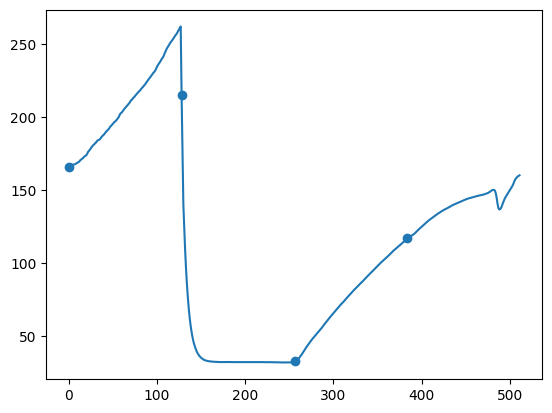

In [23]:
plt.plot(jnp.arange(num_iterations * 128), il_returns)
sequence = jnp.int32(jnp.arange(num_iterations)*128)
plt.scatter(sequence, il_returns[sequence])
plt.show()

In [24]:
il_returns[sequence] - il_returns[jnp.clip(sequence-1, min=0)]

Array([  0.        , -46.776566  ,   1.0225029 ,   0.98430634], dtype=float32)

In [25]:
policy_losses = jnp.concatenate(imitation_policy_loss)
critic_losses = jnp.concatenate(imitation_critic_loss)

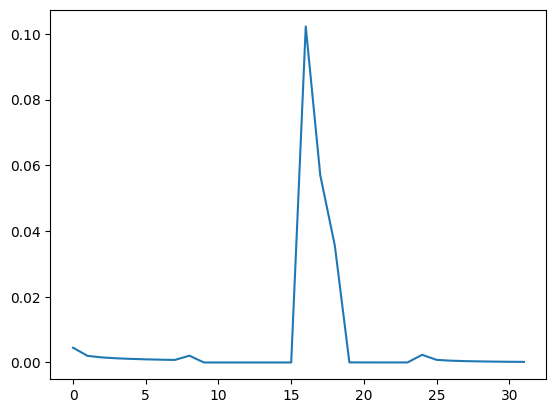

In [26]:
plt.plot(jnp.arange(policy_losses.shape[0]), policy_losses)
plt.show()

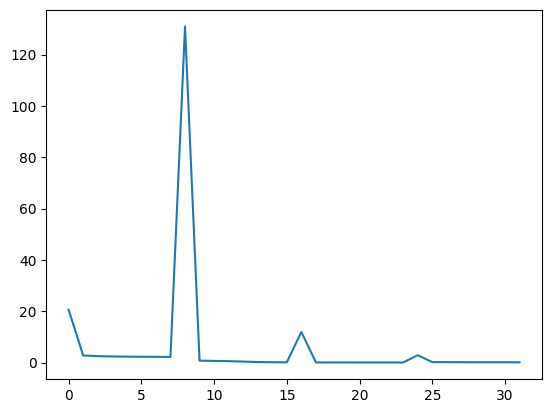

In [27]:
plt.plot(jnp.arange(critic_losses.shape[0]), critic_losses)
plt.show()

In [28]:
# new_states.[1]

In [29]:
# next_states = jax.vmap(env.step)(new_states, actions)

In [30]:
jnp.mean(
    states.reward
)

Array(0.6629753, dtype=float32)

In [31]:


# emit off-springs

# mutate

# distillate
